假设 batch_size 为 2，两个输入的序列长度分别为 1 和 10，模型的输入尺寸为 [2, 10, hidden_dim]，理论上讲，BatchNorm 计算均值和方差应该针对这 11 个向量进行，但是由于第一个输入有 9 个位置都是 padding，所以直接对 [2, 10, hidden_dim] 的模型输入做 BatchNorm 实际将这 9 个 padding 也纳入到了均值和方差的计算过程中，显然不对。

LayerNorm，在做归一化时直接不考虑序列这一维度，只在每一个位置的特征内部自己做归一化，即**针对每一位置的维度为hidden_dim的特征单独计算均值和方差**，这样的话就可以避免序列长度不同对于归一化的影响。

**BatchNorm**:
$$
\begin{aligned}
\mu_B &= \frac{1}{m} \sum_{i=1}^{m} x_i \\
\sigma_B^2 &= \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_B)^2 \\
\hat{x}_i &= \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}} \\
y_i &= \gamma \hat{x}_i + \beta
\end{aligned}
$$

**LayerNorm**:
$$
\begin{aligned}
\mu_L &= \frac{1}{H} \sum_{i=1}^{H} x_i \\
\sigma_L^2 &= \frac{1}{H} \sum_{i=1}^{H} (x_i - \mu_L)^2 \\
\hat{x}_i &= \frac{x_i - \mu_L}{\sqrt{\sigma_L^2 + \epsilon}} \\
y_i &= \gamma \hat{x}_i + \beta
\end{aligned}
$$

**RMSNorm**:


$$
\begin{aligned}\mathbf{v} & =\left[v_{1}, v_{2}, \cdots, v_{d}\right] \\\operatorname{RMS}(\mathbf{v}) & =\sqrt{\frac{1}{d} \sum_{i=1}^{d} v_{i}^{2}} \\\forall i \in\{1, \cdots, d\}, o_{i} & =\frac{v_{i}}{\operatorname{RMS}(\mathbf{v})} g_{i}\end{aligned}
$$

In [14]:
import torch
import torch.nn as nn

batch_size = 2
seq_len = 10
hidden_dim = 512

x = torch.randn(batch_size, seq_len, hidden_dim) * 1.5 + 2.0

In [11]:
batch_norm = nn.BatchNorm1d(hidden_dim)
x_bn = x.transpose(1, 2)
x_out = batch_norm(x_bn).transpose(1, 2)
x_out.shape

torch.Size([2, 10, 512])

In [15]:
layer_norm = nn.LayerNorm(hidden_dim)
x_out = layer_norm(x)
x_out.shape

torch.Size([2, 10, 512])

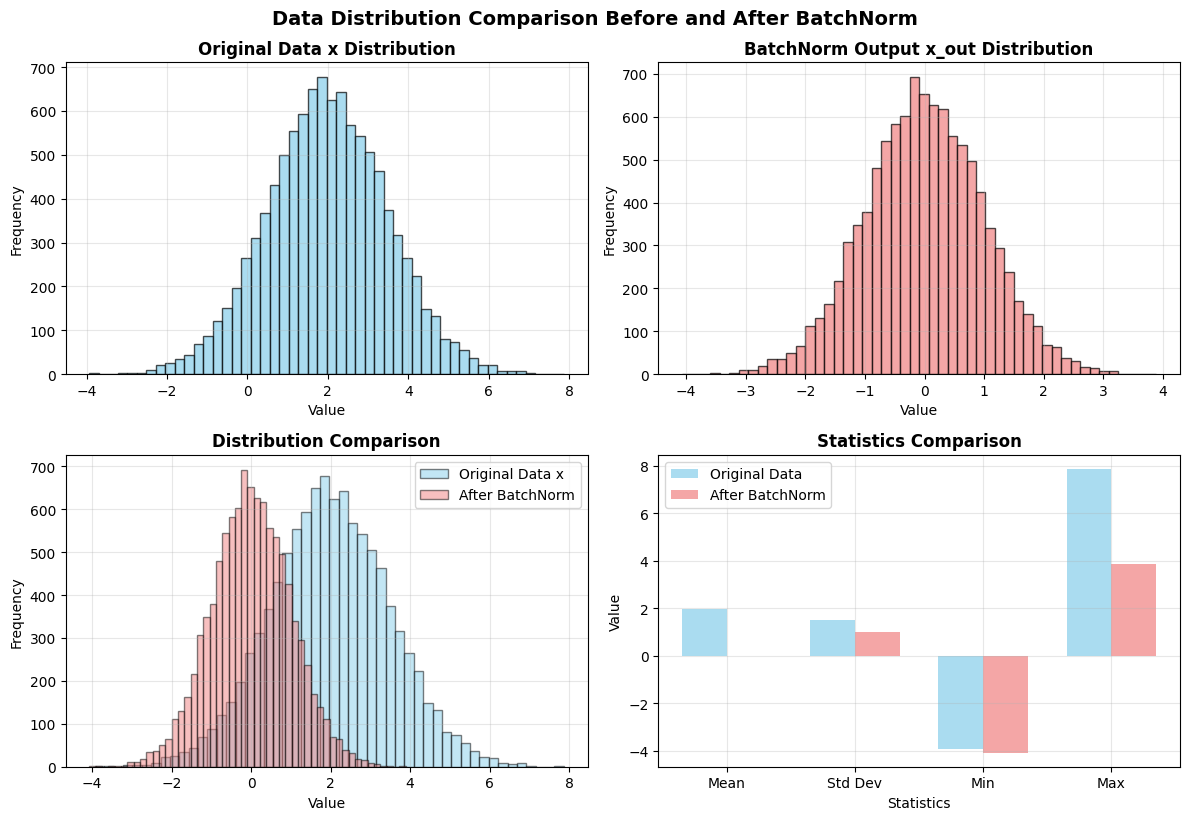

Original data x:
  Shape: torch.Size([2, 10, 512])
  Mean: 1.983567
  Std Dev: 1.501983
  Min: -3.931097
  Max: 7.867073

After BatchNorm x_out:
  Shape: torch.Size([2, 10, 512])
  Mean: 0.000000
  Std Dev: 0.999998
  Min: -4.070786
  Max: 3.886705


In [16]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Original data x distribution
x_flat = x.flatten().detach().numpy()
axes[0, 0].hist(x_flat, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Original Data x Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# BatchNorm output x_out distribution
x_bn_flat = x_out.flatten().detach().numpy()
axes[0, 1].hist(x_bn_flat, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('BatchNorm Output x_out Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Distribution comparison
axes[1, 0].hist(x_flat, bins=50, alpha=0.5, color='skyblue', label='Original Data x', edgecolor='black')
axes[1, 0].hist(x_bn_flat, bins=50, alpha=0.5, color='lightcoral', label='After BatchNorm', edgecolor='black')
axes[1, 0].set_title('Distribution Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Statistics comparison
stats_data = {
    'Mean': [x_flat.mean(), x_bn_flat.mean()],
    'Std Dev': [x_flat.std(), x_bn_flat.std()],
    'Min': [x_flat.min(), x_bn_flat.min()],
    'Max': [x_flat.max(), x_bn_flat.max()]
}

x_pos = np.arange(len(stats_data))
width = 0.35

for i, (stat_name, values) in enumerate(stats_data.items()):
    axes[1, 1].bar(i - width/2, values[0], width, label='Original Data' if i == 0 else "", 
                   color='skyblue', alpha=0.7)
    axes[1, 1].bar(i + width/2, values[1], width, label='After BatchNorm' if i == 0 else "", 
                   color='lightcoral', alpha=0.7)

axes[1, 1].set_title('Statistics Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Statistics')
axes[1, 1].set_ylabel('Value')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(stats_data.keys())
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Data Distribution Comparison Before and After BatchNorm', fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Print detailed statistics
print(f"Original data x:")
print(f"  Shape: {x.shape}")
print(f"  Mean: {x_flat.mean():.6f}")
print(f"  Std Dev: {x_flat.std():.6f}")
print(f"  Min: {x_flat.min():.6f}")
print(f"  Max: {x_flat.max():.6f}")

print(f"\nAfter BatchNorm x_out:")
print(f"  Shape: {x_out.shape}")
print(f"  Mean: {x_bn_flat.mean():.6f}")
print(f"  Std Dev: {x_bn_flat.std():.6f}")
print(f"  Min: {x_bn_flat.min():.6f}")
print(f"  Max: {x_bn_flat.max():.6f}")

In [20]:
import torch
import torch.nn as nn

class BatchNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))

    def forward(self, x):
        mean = torch.mean(x, dim=0, keepdim=True)
        var = torch.var(x, dim=0, unbiased=False, keepdim=True)
        return self.gamma * (x - mean / torch.sqrt(var + self.eps)) + self.beta

class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))

    def forward(self, x):
        mean = torch.mean(x, dim=-1, keepdim=True)
        var = torch.var(x, dim=-1, unbiased=False, keepdim=True)
        return self.gamma * (x - mean / torch.sqrt(var + self.eps)) + self.beta

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        return x / rms * self.weight

batch_size, seq_len, hidden_dim = 4, 10, 16
x = torch.randn(batch_size, seq_len, hidden_dim)

bn = BatchNorm(hidden_dim)
ln = LayerNorm(hidden_dim)
rms = RMSNorm(hidden_dim)

print("BatchNorm:", bn(x).shape)
print("LayerNorm:", ln(x).shape)
print("RMSNorm:", rms(x).shape)

BatchNorm: torch.Size([4, 10, 16])
LayerNorm: torch.Size([4, 10, 16])
RMSNorm: torch.Size([4, 10, 16])


如下是在一个完整的 Transformer 前向传播中的归一化模块插入。

In [34]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.RMSNorm(hidden_dim)
    
    def forward(self, x, mask=None):
        # Pre-norm structure (commonly used in modern Transformer)
        attn_out, _ = self.attention(self.norm1(x), self.norm1(x), self.norm1(x), attn_mask=mask)
        x += attn_out
        ffn_out = self.ffn(self.norm2(x))
        x += ffn_out
        return x

# Test Transformer Block
block = TransformerBlock(hidden_dim, num_heads=8)
output = block(x, mask=torch.randn(32, 10, 10))
print(f"Transformer Block output shape: {output.shape}")

Transformer Block output shape: torch.Size([4, 10, 16])
